# Nairobi SDG 1 Poverty Indicators Analysis

We calculate the indicator's for the Sustainable Development Goal 1: No Poverty for Nairobi subcounties using the PovertyMapper class python function we created.



In [28]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Get the project root directory dynamically
current_dir = Path.cwd()
if current_dir.name == 'notebooks':
    project_root = current_dir.parent
else:
    project_root = current_dir

# Adding the src path to our current directory
src_path = project_root/"src"
sys.path.insert(0, str(src_path))

# Specifying output path
figure_path = project_root/"outputs/figures"

# Import our custom modules
from poverty_mapper import PovertyMapper
from config import clean_data_dir, clean_data_file, poverty_rates, figures_dir, outputs_dir, project_dir, processed_data_dir

# 1. Data Loading and Preparation
Load the cleaned census data and preparte it for analysis

In [2]:
# Load the cleaned census data
try:
    df = pd.read_csv(clean_data_file)
    subcounty_df = df[df['Administrative_level'] == 'Sub-County'].copy()
    print(f"Loaded data for {len(subcounty_df)} subcounties")
    print(f"Subcounties: {subcounty_df['Administrative_Unit'].tolist()}")
except Exception as e:
    print(f"Error loading data {e}")
    print(f"Trying to load data from: {config.clean_data_file}")
    print(f"File exists: {config.clean_data_file.exists()}")


Loaded data for 11 subcounties
Subcounties: ['        DAGORETTI', '        EMBAKASI', '        KAMUKUNJI', '        KASARANI', '        KIBRA', "        LANG'ATA", '        MAKADARA', '        MATHARE', '        NJIRU', '        STAREHE', '        WESTLANDS']


In [3]:
# Display basic data information
print("Dataset Information:")
subcounty_df.info()

print("\nSummary Statistics")
subcounty_df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, 1 to 237
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative_Unit      11 non-null     object 
 1   Administrative_level     11 non-null     object 
 2   Total_Population         11 non-null     float64
 3   Male_Population          11 non-null     float64
 4   Female_Population        11 non-null     float64
 5   Total_Households         11 non-null     float64
 6   Conventional_Households  11 non-null     float64
 7   Group_Quarters           11 non-null     object 
 8   Land_Area_SqKm           11 non-null     float64
 9   Population_Density       11 non-null     float64
dtypes: float64(7), object(3)
memory usage: 968.0+ bytes

Summary Statistics


,Total_Population,Male_Population,Female_Population,Total_Households,Conventional_Households,Land_Area_SqKm,Population_Density
count,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
mean,399733.909091,199313.818182,200397.818182,136989.818182,135879.636364,63.988187,16399.181818
std,278257.143772,136387.989720,141910.494885,97644.461928,97444.901104,67.019937,18739.335494
min,185777.000000,94199.000000,91569.000000,61690.000000,60187.000000,2.996270,911.000000
25%,202026.500000,101610.000000,100401.000000,69875.000000,68094.000000,11.934915,6942.000000
50%,268276.000000,136670.000000,131599.000000,84365.000000,83680.000000,29.126620,11460.000000
75%,530345.000000,262646.500000,267667.500000,179826.000000,179720.500000,91.902035,15730.500000
max,988808.000000,492476.000000,496270.000000,347955.000000,346462.000000,216.836210,68940.000000


In [4]:
# Convert the column from type object to numeric
subcounty_df['Group_Quarters'] = pd.to_numeric(subcounty_df['Group_Quarters'], errors='coerce')

# Clean up place holder values for missing values
# Replace '-' with NaN
subcounty_df.replace('-', pd.NA, inplace=True)


In [5]:
# Step 1: Replace all '-' strings with NaN across the entire DataFrame
subcounty_df.replace('-', pd.NA, inplace=True)

# Step 2: Identify all columns that should be numeric
numeric_columns = ['Group_Quarters']  # Add all relevant columns

# Step 3: Convert each to numeric, coercing errors
for col in numeric_columns:
    subcounty_df[col] = pd.to_numeric(subcounty_df[col], errors='coerce')


### Poverty Indicator Calculations
Use the poverty mapper class to calculate poverty indicators

In [10]:
# Initialize the poverty mapper
mapper = PovertyMapper()

# Calculate poverty indicators
results = mapper.calculate_subcounty_poverty_indicators(subcounty_df)

# Display results
print(f"Results Shape: {results.shape}")
results.head()
results.columns

Results Shape: (11, 27)


Index(['Administrative_Unit', 'Administrative_level', 'Total_Population',
       'Male_Population', 'Female_Population', 'Total_Households',
       'Conventional_Households', 'Group_Quarters', 'Land_Area_SqKm',
       'Population_Density', 'subcounty_name', 'avg_household_size',
       'population_density', 'gender_ratio', 'gender_imbalance_factor',
       'size_adjustment', 'density_adjustment', 'gender_adjustment',
       'group_quarters_ratio', 'institutional_adjustment', 'total_adjustment',
       'subcounty_overall_poverty_rate', 'subcounty_food_poverty_rate',
       'subcounty_hardcore_poverty_rate', 'estimated_poor_population',
       'estimated_food_poor_population', 'sdg1_progress_category'],
      dtype='object')

### Results Summary and Analysis

In [12]:
# Calculate key statistics

print("Poverty Statistics Summary:")

poverty_statistics = {
    'Overall Poverty Rate:': {
        'Mean': results['subcounty_overall_poverty_rate'].mean(),
        'Min':results['subcounty_overall_poverty_rate'].min(),
        'Max':results['subcounty_overall_poverty_rate'].max(),
        'Std':results['subcounty_overall_poverty_rate'].std()
    },

    'Food Poverty Rate: ': {
        'Mean': results['subcounty_food_poverty_rate'].mean(),
        'Min': results['subcounty_food_poverty_rate'].min(),
        'Max': results['subcounty_food_poverty_rate'].max(),
        'Std': results['subcounty_food_poverty_rate'].std()    
    },
}

for indicator, stats in poverty_statistics.items():
    print(f"\n{indicator}: ")
    for stat_name, value in stats.items():
        print(f" {stat_name}: {value:.1f}%")

# SDG porgress distribution
print('\n SDG Progress Distribution:')
progress_counts = results['sdg1_progress_category'].value_counts()
for progress, count in progress_counts.items():
    print(f" {progress}: {count} subcounties")

Poverty Statistics Summary:

Overall Poverty Rate:: 
 Mean: 7.8%
 Min: 5.1%
 Max: 11.2%
 Std: 2.6%

Food Poverty Rate: : 
 Mean: 9.7%
 Min: 6.3%
 Max: 14.0%
 Std: 3.2%

 SDG Progress Distribution:
 Good Progress: 11 subcounties


## Data Visualization

In [13]:
# define plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

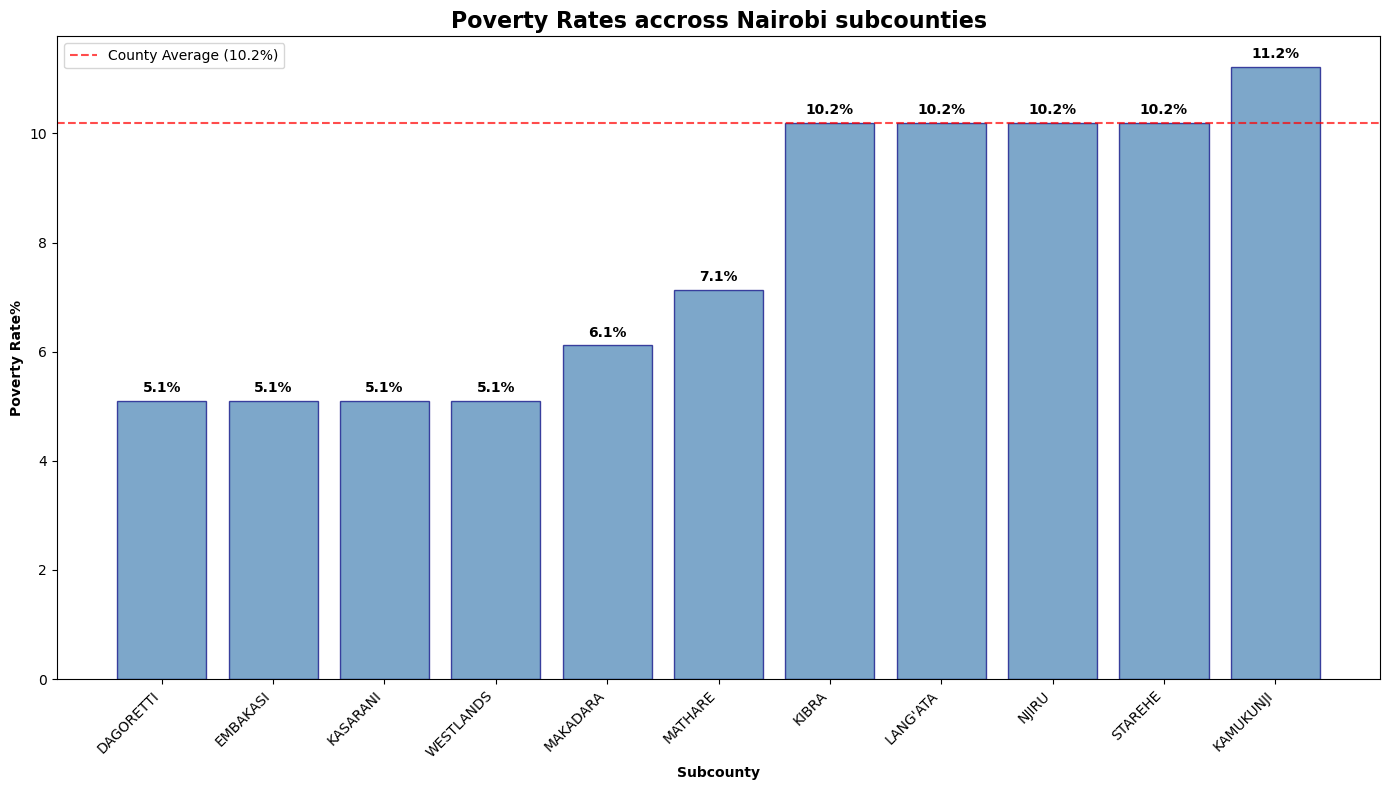

In [19]:
# Bar chart of Poverty rates by subcounty
from matplotlib.lines import lineStyles
from config import poverty_rates

fig, ax = plt.subplots(figsize = (14, 8))

# Sort the poverty rates for better visualization
sorted_results = results.sort_values('subcounty_overall_poverty_rate', ascending = True)

x_pos = np.arange(len(sorted_results))
bars = ax.bar(x_pos, sorted_results['subcounty_overall_poverty_rate'],
                color = 'steelblue', alpha=0.7, edgecolor='navy')

# Customize the plot
ax.set_xlabel('Subcounty', fontweight = 'bold')
ax.set_ylabel('Poverty Rate%', fontweight = 'bold')
ax.set_title('Poverty Rates accross Nairobi subcounties', fontsize = 16, fontweight = 'bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(sorted_results['Administrative_Unit'], rotation = 45, ha='right')


# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

# Add county average line
county_avg = poverty_rates['overall_poverty']
ax.axhline(y = county_avg, color = 'red', linestyle = '--', alpha=0.7,
            label=f'County Average ({county_avg}%)')

ax.legend()
plt.tight_layout()
# Save the figure
plt.savefig(figures_dir/'poverty-rates.png')
plt.show()

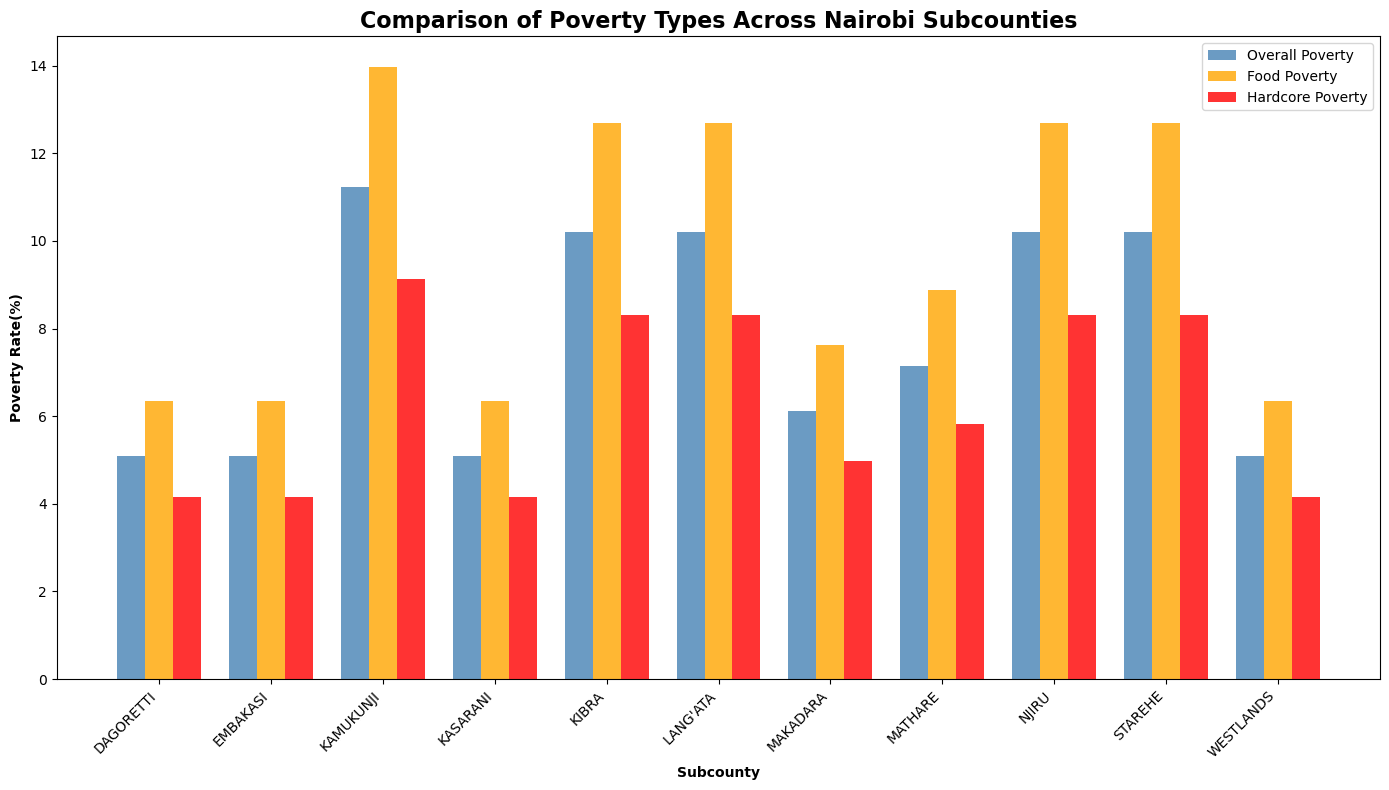

In [24]:
# Comparison of different types of poverty rates
fig, ax = plt.subplots(figsize = (14, 8))

# Prepare data for grouped barchart
subcounties = results['Administrative_Unit']
x_pos = np.arange(len(subcounties))
width  = 0.25

# Create grouped bars
bars1 = ax.bar(x_pos - width, results['subcounty_overall_poverty_rate'], width,
                label = 'Overall Poverty', color = 'steelblue', alpha=0.8)
bars2 = ax.bar(x_pos, results['subcounty_food_poverty_rate'], width,
                label = 'Food Poverty', color = 'orange', alpha=0.8)
bars3 = ax.bar(x_pos + width, results['subcounty_hardcore_poverty_rate'], width,
                label = 'Hardcore Poverty', color = 'red', alpha=0.8)


# Customize the Plot
ax.set_xlabel('Subcounty', fontweight = 'bold')
ax.set_ylabel('Poverty Rate(%)', fontweight = 'bold')
ax.set_title('Comparison of Poverty Types Across Nairobi Subcounties',
                fontsize = 16, fontweight = 'bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(subcounties, rotation = 45, ha='right')
ax.legend()


# Show Plot
plt.tight_layout()

# Save the figure
plt.savefig(figures_dir/'poverty-comparison-types.png')
plt.show()

### Export Results
Save the results for further analysis and reporting

In [26]:
# Importing and Loading libraries for documentation
from docx import Document
from docx.shared import Inches
from docx.enum.text import WD_ALIGN_PARAGRAPH
from docx.oxml.shared import OxmlElement, qn


# Specifying the Output Directory
output_dir = project_root/'outputs'
reports_dir = output_dir/'reports'
reports_dir.mkdir(parents=True, exist_ok = True)


In [29]:
# Exporting Results to csv
results_file = processed_data_dir / 'nairobi_subcounty_poverty_indicators.csv'
results.to_csv(results_file, index=False)


In [ ]:
# Imorting the summary report's function
from summary_report import create_complete_poverty_report
from config import reports_dir

# Calling the function
report_file = create_complete_poverty_report(results, reports_dir)

Complete summary report exported to: c:\Users\Administrator\Desktop\Nairobi SDG Indicators\outputs\reports\nairobi_poverty_indicators_summary_report.docx
Report includes 3 poverty indicators and 1 progress categories

Key Findings:
  • Highest poverty: KAMUKUNJI (11.2%)
  • Lowest poverty: DAGORETTI (5.1%)
  • Average poverty: 7.8%
  • County reference: 10.2%
  • Total estimated poor population: 309,046
